In [1]:
import sys
sys.path.append('/data1/caption_bias/models/research/im2txt/coco-caption/')
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import numpy as np
from bias_detection import *
import json

In [2]:
#json file for annotations for entire set
save_file = '/data/lisaanne/fairness/checkpoints/blocked_image_blockedLW10/result-checkpoint-528015.json'   
predicted_captions = json.load(open(save_file))

In [3]:
coco = COCO('coco/annotations/captions_val2014.json')
generation_coco = coco.loadRes(save_file)
coco_evaluator = COCOEvalCap(coco, generation_coco)
print "Evaluation over the entire MSCOCO set:"
coco_evaluator.evaluate()

loading annotations into memory...
0:00:00.712253
creating index...
index created!
Loading and preparing results...     
DONE (t=0.12s)
creating index...
index created!
Evaluation over the entire MSCOCO set:
tokenization...
setting up scorers...
computing Bleu score...
{'reflen': 376639, 'guess': [377748, 337244, 296740, 256236], 'testlen': 377748, 'correct': [181441, 52402, 15447, 6026]}
ratio: 1.00294446406
Bleu_1: 0.480
Bleu_2: 0.273
Bleu_3: 0.157
Bleu_4: 0.098
computing METEOR score...
METEOR: 0.131
computing Rouge score...
ROUGE_L: 0.351
computing CIDEr score...
CIDEr: 0.218


In [4]:
print "Evaluation over the biased set:"

#First create json with unbiased data.  
#Kaylee -- you might want to update this with the script you wrote; I made a text file with all the image names
#since this seemed like something I would use a lot (used your script to make this txt file)

bias_ids = open('/data/lisaanne/fairness/data/img_names.txt').readlines()
bias_ids = [int(id) for id in bias_ids]

bias_captions = []
for caption in predicted_captions:
    if caption['image_id'] in bias_ids:
        bias_captions.append(caption)
        
bias_save_file = save_file.replace('.json', '_bias.json')
with open(bias_save_file, 'w') as outfile:
    json.dump(bias_captions, outfile)

generation_coco = coco.loadRes(bias_save_file)
coco_evaluator = COCOEvalCap(coco, generation_coco)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
coco_evaluator.params['image_id'] = generation_coco.getImgIds()

print "Evaluation over the biased MSCOCO set:"
coco_evaluator.evaluate()

Evaluation over the biased set:
Loading and preparing results...     
DONE (t=0.06s)
creating index...
index created!
Evaluation over the biased MSCOCO set:
tokenization...
setting up scorers...
computing Bleu score...
{'reflen': 101441, 'guess': [99785, 88862, 77939, 67016], 'testlen': 99785, 'correct': [56718, 20760, 7273, 3146]}
ratio: 0.983675239795
Bleu_1: 0.559
Bleu_2: 0.358
Bleu_3: 0.228
Bleu_4: 0.153
computing METEOR score...
METEOR: 0.178
computing Rouge score...
ROUGE_L: 0.412
computing CIDEr score...
CIDEr: 0.374


In [5]:
bias_ids = [int(id) for id in bias_ids]
bias_ids = set(bias_ids) & set(coco_evaluator.imgToEval.keys())
bleu_3 = np.mean([coco_evaluator.imgToEval[id]["Bleu_3"] for id in bias_ids])
bleu_4 = np.mean([coco_evaluator.imgToEval[id]["Bleu_4"] for id in bias_ids])
cider = np.mean([coco_evaluator.imgToEval[id]["CIDEr"] for id in bias_ids])
meteor = np.mean([coco_evaluator.imgToEval[id]["METEOR"] for id in bias_ids])

print "Bleu_3: %f" %bleu_3
print "Bleu_4: %f" %bleu_4
print "METEOR: %f" %meteor
print "CIDEr: %f" %cider

Bleu_3: 0.144256
Bleu_4: 0.072912
METEOR: 0.187850
CIDEr: 0.373603


In [6]:
#Get F1 scores for man/woman + some eval preprocessing
#From Kaylee's code

img_2_anno_dict = create_dict_from_list(pickle.load(open(target_train)))
img_2_anno_dict.update(create_dict_from_list(pickle.load(open(target_test))))
img_2_anno_dict.update(create_dict_from_list(pickle.load(open(target_val))))

img_2_anno_dict_simple = {}
for key, value in img_2_anno_dict.iteritems():
    id = int(key.split('_')[-1].split('.jpg')[0])
    img_2_anno_dict_simple[id] = {}
    img_2_anno_dict_simple[id]['male'] = value[0]
    img_2_anno_dict_simple[id]['female'] = value[1]        

In [7]:
def accuracy(predicted):
    f_tp = 0.
    f_fp = 0.
    f_tn = 0.
    f_other = 0.
    f_total = 0.
    
    
    m_tp = 0.
    m_fp = 0.
    m_tn = 0.
    m_other = 0.
    m_total = 0.
    
    for prediction in predicted:
        image_id = prediction['image_id']
        male = img_2_anno_dict_simple[image_id]['male']
        female = img_2_anno_dict_simple[image_id]['female']
        pred_male = classified_as_man(prediction['caption'].split(' '))
        pred_female = classified_as_woman(prediction['caption'].split(' '))
        if (female & pred_female):
            f_tp += 1
        if (male & pred_male):
            m_tp += 1
        if (male & pred_female):
            f_fp += 1
        if (female & pred_male):
            m_fp += 1
        if ((not female) & (not pred_female)):
            f_tn += 1
        if ((not male) & (not pred_male)):
            m_tn += 1
        pred_other = (not pred_male) & (not pred_female)
        if (female & pred_other):
            f_other += 1
        if (male & pred_other):
            m_other += 1
        if female:
            f_total += 1
        if male:
            m_total += 1

        
    #precision_f = (f_tp)/(f_tp+f_fp)
    #recall_f = (f_tp)/(f_tp+f_n)
    
    print "Of female images:"
    print "Woman predicted %f percent." %(f_tp/f_total)
    print "Man predicted %f percent." %(m_fp/f_total)
    print "Other predicted %f percent." %(f_other/f_total)
    
    print "Of male images:"
    print "Man predicted %f percent." %(m_tp/m_total)
    print "Woman predicted %f percent." %(f_fp/m_total)
    print "Other predicted %f percent." %(m_other/m_total)
    #precision_m = (m_tp)/(m_tp+m_fp)

In [8]:
predicted_all = json.load(open(save_file))
predicted = [p for p in predicted_all if p['image_id'] in bias_ids]

In [9]:
accuracy(predicted)

Of female images:
Woman predicted 0.000000 percent.
Man predicted 0.000000 percent.
Other predicted 1.000000 percent.
Of male images:
Man predicted 0.000000 percent.
Woman predicted 0.000000 percent.
Other predicted 1.000000 percent.


In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io

save_folder_base = '/home/lisaanne/lev/data2/caption-bias/outputs/'
save_folder = save_folder_base + 'LW10/%s/%012d.png'

im_id_to_url = {}

for image in coco.dataset['images']:
    im_id_to_url[image['id']] = image['coco_url']

In [ ]:
for i, prediction in enumerate(predicted_all):
    sys.stdout.write('\r%d/%d' %(i, len(predicted_all)))
    caption = prediction['caption']
    img_id = prediction['image_id']
    if len(set([img_id]) & set(bias_ids)) > 0:
        tag = 'bias'
    else:
        tag = 'not-bias'
    url = im_id_to_url[img_id]
    image = io.imread(url)
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.savefig(save_folder %(tag, img_id))

1355/40504

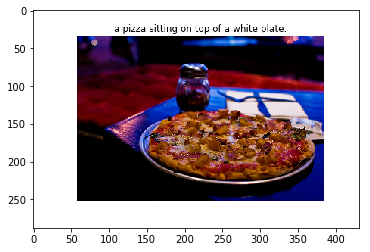

In [39]:
img=mpimg.imread(save_folder %img_id)
imgplot = plt.imshow(img)

In [17]:
print '\n'.join([pred['caption'] for pred in predicted_all])


a person sitting in a chair with a laptop.
a person sitting at a table with a laptop.
a person sitting at a table with a plate of food.
a group of people standing around a train station.
a person sitting on a bench with a dog.
a group of people walking down a street.
a group of people standing next to each other.
a person riding a bike down a street.
a person sitting on a bench with a dog.
a person sitting on a bench with a dog.
a person sitting at a table with a plate of food.
a person standing in front of a train.
a person riding a horse in a field.
a person riding a motorcycle on a city street.
a person standing in front of a television.
a person sitting on a bench with a dog.
a group of people standing around a table.
a group of people standing around a train station.
a person riding skis on a snowy surface.
a person riding a motorcycle on a street.
a person is holding a frisbee in the air.
a person riding a horse in a field.
a person riding a motorcycle down a street.
a group of p

In [19]:
len(predicted)

10923